In [1]:
# for colab only
!pip install pyspark --quiet
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pyspark
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import *
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import os
import sys
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id 
import numpy as np


In [3]:
sc = SparkContext()
spark = SparkSession.builder.appName('ml-hw').getOrCreate()
df = spark.read.csv('/content/gdrive/MyDrive/data.csv', header = True, inferSchema = True)
df=df.dropDuplicates()
df = df.select("*").withColumn("id", monotonically_increasing_id())

In [4]:
df.show()

+--------------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+---+
|    customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label| id|
+--------------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+---+
|    3655-SNQYZ|Female|          0.0|

# minor data cleaning (just deleting missing values)

In [5]:
df.columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Label',
 'id']

# counting Null values

In [6]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label| id|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+
|       253|   235|          266|    225|       242|   225|         269|          263|            230|           230|         243|             254|        264|        249|            219|     230|      

In [7]:
df.count()

7838

# counting duplicate items

In [8]:
df.groupBy('customerID','gender','SeniorCitizen','Partner','Dependents','tenure','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges','Label').count().show(50)


+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|count|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-----+
|3655-SNQYZ|Female|          0.0|    Yes|  

## حدود دویست عدد از داده ها برچسب ندارند و حذف میشوند.

In [9]:
df=df.na.drop(subset=["Label"]) 
df.show(truncate=False)

+--------------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-------------------------+--------------+------------+-----+---+
|customerID    |gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|OnlineSecurity     |OnlineBackup       |DeviceProtection   |TechSupport        |StreamingTV        |StreamingMovies    |Contract      |PaperlessBilling|PaymentMethod            |MonthlyCharges|TotalCharges|Label|id |
+--------------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-------------------------+--------------+------------+-----+---+
|3655-SNQYZ    |Female

In [10]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label| id|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+
|       193|   173|          195|    165|       178|   170|         195|          190|            164|           165|         186|             182|        209|        187|            165|     164|      

In [11]:
df.show()

+--------------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+---+
|    customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label| id|
+--------------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+---+
|    3655-SNQYZ|Female|          0.0|

In [12]:
#df=df.na.drop(subset=["customerID"]) 
#df.show(truncate=False)

In [13]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label| id|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+
|       193|   173|          195|    165|       178|   170|         195|          190|            164|           165|         186|             182|        209|        187|            165|     164|      

In [14]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Label: string (nullable = true)
 |-- id: long (nullable = false)



In [15]:
df2=df.na.drop() 
df2.show(truncate=False)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-------------------------+--------------+------------+-----+---+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|OnlineSecurity     |OnlineBackup       |DeviceProtection   |TechSupport        |StreamingTV        |StreamingMovies    |Contract      |PaperlessBilling|PaymentMethod            |MonthlyCharges|TotalCharges|Label|id |
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-------------------------+--------------+------------+-----+---+
|3655-SNQYZ|Female|0.0          |Y

In [16]:
df2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label| id|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|      

# implementing logistic regression for label prediction

## featurizing

## در این مرحله در انتخاب فیچرها حساسیت زیادی به خرج نداده و فقط آی دی خریدار را به عنوان فیچر در نظر نمیگیریم
### در مراحل آتی فیچر ها با فیلتر دقیق تری مشخص میشوند

In [17]:
hasher = FeatureHasher(inputCols=["gender", "SeniorCitizen", "Partner", "Dependents","tenure", "PhoneService", "MultipleLines", "InternetService","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges", "TotalCharges", "TotalCharges"],
                       outputCol="features")
df=df.na.drop()
featurized = hasher.transform(df)
featurized.show(truncate=False)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-------------------------+--------------+------------+-----+---+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|OnlineSecurity     |OnlineBackup       |DeviceProtection   |TechSupport        |StreamingTV        |StreamingMovies    |Contract      |PaperlessBilling|PaymentMethod            |MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                      

In [18]:
featurized=featurized["Label","features","customerID"]
featurized.show()

+-----+--------------------+----------+
|Label|            features|customerID|
+-----+--------------------+----------+
|   No|(262144,[20762,40...|3655-SNQYZ|
|   No|(262144,[20545,20...|7114-AEOZE|
|  Yes|(262144,[20762,40...|8621-MNIHH|
|  Yes|(262144,[7831,205...|4580-TMHJU|
|   No|(262144,[20762,40...|5553-AOINX|
|   No|(262144,[20545,20...|5902-WBLSE|
|   No|(262144,[20762,40...|2388-LAESQ|
|  Yes|(262144,[20545,20...|2506-CLAKW|
|   No|(262144,[4236,783...|4976-LNFVV|
|   No|(262144,[20762,40...|3642-GKTCT|
|  Yes|(262144,[20545,20...|2223-KAGMX|
|   No|(262144,[7831,207...|9003-CPATH|
|   No|(262144,[4236,207...|7634-WSWDB|
|   No|(262144,[20545,20...|6997-UVGOX|
|   No|(262144,[20762,40...|3692-JHONH|
|  Yes|(262144,[4236,783...|5202-IVJNU|
|   No|(262144,[20545,20...|7879-CGSFV|
|   No|(262144,[20545,20...|0582-AVCLN|
|   No|(262144,[7831,205...|2229-VWQJH|
|   No|(262144,[20545,20...|5524-KHNJP|
+-----+--------------------+----------+
only showing top 20 rows



In [19]:
def f(x): 
    if(x == 'Yes'):
       return 1

    else:
       return 0
#featurized.select("Label").rdd.map(lambda x: f(x[0])).collect()
#featurized.select("Label").rdd.map(lambda x: f(x[0])).map(lambda x: Row(x)).toDF(["label"]).show()
featurized=featurized.withColumn("label", when(col("Label")=='Yes', 1).otherwise(0))


In [20]:
featurized=featurized.withColumnRenamed("Label","label")
featurized.show()

+-----+--------------------+----------+
|label|            features|customerID|
+-----+--------------------+----------+
|    0|(262144,[20762,40...|3655-SNQYZ|
|    0|(262144,[20545,20...|7114-AEOZE|
|    1|(262144,[20762,40...|8621-MNIHH|
|    1|(262144,[7831,205...|4580-TMHJU|
|    0|(262144,[20762,40...|5553-AOINX|
|    0|(262144,[20545,20...|5902-WBLSE|
|    0|(262144,[20762,40...|2388-LAESQ|
|    1|(262144,[20545,20...|2506-CLAKW|
|    0|(262144,[4236,783...|4976-LNFVV|
|    0|(262144,[20762,40...|3642-GKTCT|
|    1|(262144,[20545,20...|2223-KAGMX|
|    0|(262144,[7831,207...|9003-CPATH|
|    0|(262144,[4236,207...|7634-WSWDB|
|    0|(262144,[20545,20...|6997-UVGOX|
|    0|(262144,[20762,40...|3692-JHONH|
|    1|(262144,[4236,783...|5202-IVJNU|
|    0|(262144,[20545,20...|7879-CGSFV|
|    0|(262144,[20545,20...|0582-AVCLN|
|    0|(262144,[7831,205...|2229-VWQJH|
|    0|(262144,[20545,20...|5524-KHNJP|
+-----+--------------------+----------+
only showing top 20 rows



## spliting data into training and test sets

In [21]:
train, test = featurized.randomSplit(weights=[0.8,0.2], seed=200)

In [22]:
train.show()

+-----+--------------------+----------+
|label|            features|customerID|
+-----+--------------------+----------+
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|5227-JSCFE|
|    0|(262144,[4236,783...|8046-DNVTL|
|    0|(262144,[4236,783...|8242-PDSGJ|
|    0|(262144,[4236,783...|9286-BHDQG|
|    0|(262144,[4236,783...|7321-ZNSLA|
|    0|(262144,[4236,783...|0056-EPFBG|
|    0|(262144,[4236,783...|8882-TLVRW|
|    0|(262144,[4236,783...|0230-WEQUW|
|    0|(262144,[4236,783...|0979-MOZQI|
|    0|(262144,[4236,783...|0298-XACET|
|    0|(262144,[4236,783...|7758-UJWYS|
|    0|(262144,[4236,783...|5656-MJEFC|
|    0|(262144,[4236,783...|1814-WFGVS|
|    0|(262144,[4236,783...|7274-CGTOD|
|    0|(262144,[4236,783...|3891-NLXJB|
|    0|(262144,[4236,783...|6119-SPUDB|
|    0|(262144,[4236,783...|2335-GSODA|
|    0|(262144,[4236,783...|6122-EFVKN|
|    0|(262144,[4236,783...|8208-EUMTE|
+-----+--------------------+----------+
only showing top 20 rows



In [23]:
test.show()

+-----+--------------------+----------+
|label|            features|customerID|
+-----+--------------------+----------+
|    0|(262144,[4236,783...|9674-EHPPG|
|    0|(262144,[4236,783...|6164-HAQTX|
|    0|(262144,[4236,783...|6967-PEJLL|
|    0|(262144,[4236,783...|9373-WSLOY|
|    0|(262144,[4236,783...|5337-IIWKZ|
|    0|(262144,[4236,783...|3315-IKYZQ|
|    0|(262144,[4236,783...|2361-FJWNO|
|    0|(262144,[4236,783...|2782-JEEBU|
|    0|(262144,[4236,783...|7880-XSOJX|
|    0|(262144,[4236,783...|4999-IEZLT|
|    0|(262144,[4236,783...|8898-KASCD|
|    0|(262144,[4236,783...|1430-SFQSA|
|    0|(262144,[4236,783...|8904-OPDCK|
|    0|(262144,[4236,783...|1976-AZZPJ|
|    0|(262144,[4236,783...|9309-BZGNT|
|    0|(262144,[4236,783...|6743-HHQPF|
|    0|(262144,[4236,783...|9830-ECLEN|
|    0|(262144,[4236,783...|5533-RJFTJ|
|    0|(262144,[4236,783...|8069-YQQAJ|
|    0|(262144,[4236,783...|0373-AIVNJ|
+-----+--------------------+----------+
only showing top 20 rows



## creating an instance of logistic regression

In [24]:
lr=LogisticRegression(maxIter=100,regParam=0.01) # as an estimator
lr.explainParams()

"aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)\nfamily: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)\nfeaturesCol: features column name. (default: features)\nfitIntercept: whether to fit an intercept term. (default: True)\nlabelCol: label column name. (default: label)\nlowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)\nlowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must be

# learning the model

In [25]:
model1=lr.fit(train)

### trained coefficients:

In [26]:
model1.coefficients

SparseVector(262144, {4236: 0.0685, 7831: -0.0798, 20545: -0.1284, 20762: 0.0001, 35396: 0.0064, 40671: 0.1871, 53807: -0.1501, 57644: -0.1501, 59103: -0.1501, 62450: -0.114, 72938: -0.7187, 74746: -0.0504, 77335: -0.0533, 97174: -0.132, 97284: -0.1501, 100321: 0.0995, 109041: -0.0132, 112867: -0.0995, 119757: 0.1947, 124394: 0.0685, 139220: 0.1611, 139721: -0.1501, 143274: -0.0024, 144208: -0.4525, 144894: -0.0685, 148734: 0.0504, 153197: -0.1501, 163470: 0.2836, 180881: -0.1891, 190858: 0.1149, 190991: 0.2518, 196278: 0.0731, 203276: 0.1067, 205898: -0.0523, 213513: -0.1501, 218283: 0.6693, 222701: 0.1073, 240448: -0.2087, 241506: 0.5183, 246667: -0.0002, 253914: -0.0064, 256762: -0.1834, 257928: 0.036})

# testing phase

In [27]:
new_predictions=model1.transform(test)
new_predictions.show()

+-----+--------------------+----------+--------------------+--------------------+----------+
|label|            features|customerID|       rawPrediction|         probability|prediction|
+-----+--------------------+----------+--------------------+--------------------+----------+
|    0|(262144,[4236,783...|9674-EHPPG|[3.16696456358036...|[0.95957199325292...|       0.0|
|    0|(262144,[4236,783...|6164-HAQTX|[3.47708734953441...|[0.97002875663255...|       0.0|
|    0|(262144,[4236,783...|6967-PEJLL|[2.28470838667570...|[0.90760265105399...|       0.0|
|    0|(262144,[4236,783...|9373-WSLOY|[0.62307151442803...|[0.65091679385873...|       0.0|
|    0|(262144,[4236,783...|5337-IIWKZ|[0.72943930811337...|[0.67468222054987...|       0.0|
|    0|(262144,[4236,783...|3315-IKYZQ|[2.35005672505600...|[0.91293873626355...|       0.0|
|    0|(262144,[4236,783...|2361-FJWNO|[2.16079272000952...|[0.89667301755911...|       0.0|
|    0|(262144,[4236,783...|2782-JEEBU|[0.95425393736878...|[0.7219698

# Evaluation

## comparing labels with predictions

In [28]:
new_predictions.groupBy('label', 'prediction').count().show()
TN = new_predictions.filter('prediction = 0 AND label = prediction').count()
TP = new_predictions.filter('prediction = 1 AND label = prediction').count()
FN = new_predictions.filter('prediction = 0 AND label = 1').count()
FP = new_predictions.filter('prediction = 1 AND label = 0').count()
new_accuracy = (TN + TP) / (TN + TP + FN + FP)
new_accuracy
new_Precision = TP/(TP+FP)
new_Recall = TP/(TP+FN)
new_F_Measure=(2*new_Precision*new_Recall)/(new_Precision+new_Recall)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  194|
|    0|       0.0|  932|
|    1|       1.0|  196|
|    0|       1.0|  104|
+-----+----------+-----+



# filling missing values with prediction:


# بررسی ستون های دیتافریم
## 1.  آی دی مشتری
### این ستون مسلما تاثیری بر ترک مشتری نخواهد داشت و نباید فیچر باشد
## 2. جنسیت x
### این ستون هم به نظر نمی رسد تاثیر چندانی بر ترک مشتری داشته باشد در ادامه بیشتر اثر این ستون را بررسی میکنیم

In [29]:
df2=df.na.drop() 
df2 = df2.dropDuplicates() # removing dupplicates


In [30]:
df.groupBy('gender', 'Label').count().show()


+------+-----+-----+
|gender|Label|count|
+------+-----+-----+
|  Male|   No| 2621|
|  Male|  Yes|  930|
|Female|   No| 2548|
|Female|  Yes|  939|
+------+-----+-----+



In [31]:
df2.groupBy('gender', 'Label').count().show()


+------+-----+-----+
|gender|Label|count|
+------+-----+-----+
|  Male|   No| 2621|
|  Male|  Yes|  930|
|Female|   No| 2548|
|Female|  Yes|  939|
+------+-----+-----+



# همانطور که دیده میشود مردان و زنان تقریبا به اندازه یکدیگر لیبل بله و خیر خورده اند لذا این فیچر باید از لیست فیچرها خارج شود.

# 3. بازنشستگی

In [32]:
df.groupBy('SeniorCitizen', 'Label').count().show()


+-------------+-----+-----+
|SeniorCitizen|Label|count|
+-------------+-----+-----+
|         17.0|   No|    1|
|         14.0|  Yes|    2|
|          1.0|  Yes|  476|
|          0.0|   No| 4496|
|          1.0|   No|  666|
|          0.0|  Yes| 1391|
|         14.0|   No|    6|
+-------------+-----+-----+



# همانطور که دیده میشود تعداد مقادیر اوت لایر داریم که بنا را بر این میگیریم که این فیچر فقط مقادیر صفر و یک میتواند بپذیرد و تمام مقادیر غیر صفر را یک فرض میکنیم به این معنی که شخص بازنشسته است

In [33]:
df2=df2.withColumn("SeniorCitizen", when(col("SeniorCitizen")>=1, 1).otherwise(0))
df2.groupBy('SeniorCitizen', 'Label').count().show()
df1=spark.read.csv('/content/gdrive/MyDrive/data.csv', header = True, inferSchema = True)
df1=df1.withColumn("SeniorCitizen", when(col("SeniorCitizen")>=1, 1).when(col("SeniorCitizen")==0, 0))
from pyspark.sql.functions import monotonically_increasing_id 
df1=df1.dropDuplicates()
df1 = df1.select("*").withColumn("id", monotonically_increasing_id())

+-------------+-----+-----+
|SeniorCitizen|Label|count|
+-------------+-----+-----+
|            1|   No|  673|
|            0|   No| 4496|
|            0|  Yes| 1391|
|            1|  Yes|  478|
+-------------+-----+-----+



In [34]:
df1.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+---+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label| id|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+---+
|2225-ZRGSG|Female|            0|    Yes|       Y

In [35]:
df2=df2.withColumn("Label", when(col("Label")=='Yes', 1).otherwise(0))
df1=df1.withColumn("Label", when(col("Label")=='Yes', 1).when(col("Label")=='No', 0))

df2.stat.corr('SeniorCitizen', 'Label')

0.149916181595582

# همانطور که در بالا دیده میشود کورلیشن موجود نیز قابل صرف نظر کردن نیست هرچند مقدار کمی دارد

In [36]:
df.groupBy('Partner').count().show()


+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3643|
|    Yes| 3395|
+-------+-----+



In [37]:
df2.groupBy('Partner').count().show()


+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3643|
|    Yes| 3395|
+-------+-----+



In [38]:
df2.groupBy('Partner', 'Label').count().show()


+-------+-----+-----+
|Partner|Label|count|
+-------+-----+-----+
|    Yes|    0| 2726|
|     No|    1| 1200|
|    Yes|    1|  669|
|     No|    0| 2443|
+-------+-----+-----+



In [39]:
df2=df2.withColumn("Partner", when(col("Partner")=='Yes', 1).otherwise(0))
df2.stat.corr('Partner', 'Label')
df1=df1.withColumn("Partner", when(col("Partner")=='Yes', 1).when(col("Partner")=='No', 0))


# اینطور میتوان برداشت کرد که پارتنر داشتن بر ماندن در سایت اثر دارد لذا از فاکتورهای موثر بر تصمیم گیری می باشد

# 4.Dependents

In [40]:
df.groupBy('Dependents').count().show()


+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4938|
|       Yes| 2100|
+----------+-----+



In [41]:
df2.groupBy('Dependents', 'Label').count().show()


+----------+-----+-----+
|Dependents|Label|count|
+----------+-----+-----+
|       Yes|    0| 1774|
|        No|    1| 1543|
|       Yes|    1|  326|
|        No|    0| 3395|
+----------+-----+-----+



In [42]:
df2=df2.withColumn("Dependents", when(col("Dependents")=='Yes', 1).otherwise(0))
df1=df1.withColumn("Dependents", when(col("Dependents")=='Yes', 1).when(col("Dependents")=='No', 0))


# از جدول بالا میتوان مشاهد کرد کسانی که وضعیت استقلالشان خیر است  دو برابر کسانی که بله می باشد احتمال دارد که  برچسب 1 بخورند
## این معیار موثر است و حفظ میشود.

# 5.tenure

In [43]:
df.groupBy('tenure').count().show()


+------+-----+
|tenure|count|
+------+-----+
|  70.0|  118|
|   8.0|  122|
|  67.0|   98|
|  69.0|   95|
|   7.0|  130|
|  49.0|   66|
|  29.0|   72|
|  64.0|   80|
|  47.0|   68|
|  42.0|   65|
|-598.0|    1|
|  44.0|   51|
|  35.0|   88|
|  62.0|   69|
|  18.0|   97|
|-538.0|    1|
|  39.0|   56|
|   1.0|  613|
|  34.0|   65|
|  37.0|   65|
+------+-----+
only showing top 20 rows



{'boxes': [<matplotlib.lines.Line2D at 0x7f634e183650>],
 'caps': [<matplotlib.lines.Line2D at 0x7f634e18e650>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f634e114690>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f634e114150>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f634e9a23d0>,
  <matplotlib.lines.Line2D at 0x7f634e18e110>]}

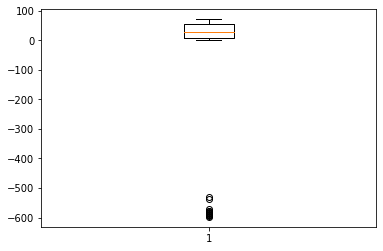

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

ten = df2.select("tenure").rdd.flatMap(lambda x: x).collect()
plt.boxplot(ten)


{'boxes': [<matplotlib.lines.Line2D at 0x7f634dc1edd0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f634dc25dd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f634dc2ce10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f634dc2c8d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f634dc25350>,
  <matplotlib.lines.Line2D at 0x7f634dc25890>]}

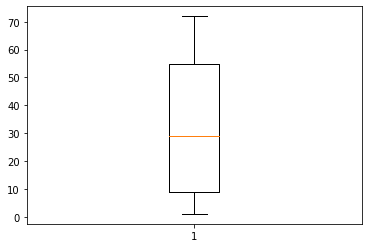

In [45]:
df2=df2.where("tenure>0")
#df1=df1.where("tenure>0")

ten = df2.select("tenure").rdd.flatMap(lambda x: x).collect()
plt.boxplot(ten)

In [46]:
#df1=df1.where("tenure>0")


In [47]:
df2.groupBy('tenure').count().show()


+------+-----+
|tenure|count|
+------+-----+
|  70.0|  118|
|   8.0|  122|
|  67.0|   98|
|  69.0|   95|
|   7.0|  130|
|  49.0|   66|
|  29.0|   72|
|  64.0|   80|
|  47.0|   68|
|  42.0|   65|
|  44.0|   51|
|  35.0|   88|
|  62.0|   69|
|  18.0|   97|
|  39.0|   56|
|   1.0|  613|
|  34.0|   65|
|  37.0|   65|
|  25.0|   79|
|  36.0|   50|
+------+-----+
only showing top 20 rows



In [48]:
df2.groupBy('tenure', 'Label').count().show()


+------+-----+-----+
|tenure|Label|count|
+------+-----+-----+
|  34.0|    0|   53|
|  48.0|    0|   55|
|  70.0|    0|  107|
|  51.0|    1|    8|
|  71.0|    1|    6|
|  12.0|    1|   38|
|  40.0|    1|   13|
|  61.0|    0|   68|
|   2.0|    1|  123|
|  69.0|    1|    8|
|  19.0|    1|   19|
|  43.0|    0|   50|
|  33.0|    1|   14|
|  17.0|    1|   26|
|  57.0|    0|   57|
|  15.0|    0|   61|
|   1.0|    0|  233|
|  49.0|    0|   51|
|  50.0|    0|   58|
|  44.0|    1|    6|
+------+-----+-----+
only showing top 20 rows



In [49]:
df2.stat.corr('tenure', 'Label')

-0.354572862900859

# با توجه به مقدار کورلیشن حذف نمیشود

# 5.PhoneService 

In [50]:
df.groupBy('PhoneService', 'Label').count().show()

+------------+-----+-----+
|PhoneService|Label|count|
+------------+-----+-----+
|         Yes|  Yes| 1699|
|          No|   No|  511|
|         Yes|   No| 4658|
|          No|  Yes|  170|
+------------+-----+-----+



In [51]:
df2=df2.withColumn("PhoneService", when(col("PhoneService")=='Yes', 1).otherwise(0))
df2.stat.corr('PhoneService', 'Label')
df1=df1.withColumn("PhoneService", when(col("PhoneService")=='Yes', 1).when(col("PhoneService")=='No', 0))


In [52]:
df2.groupBy('PhoneService', 'Label').count().show()


+------------+-----+-----+
|PhoneService|Label|count|
+------------+-----+-----+
|           1|    0| 4645|
|           1|    1| 1697|
|           0|    0|  511|
|           0|    1|  170|
+------------+-----+-----+



In [53]:
df2.groupBy( 'Label').count().show()


+-----+-----+
|Label|count|
+-----+-----+
|    1| 1867|
|    0| 5156|
+-----+-----+



In [54]:
df2.stat.corr('PhoneService', 'Label')

0.012022136884067771

# این پارامتر اثر دارد (حذف نمیشود)

# 6.MultipleLines

In [55]:

df2=df2.withColumn("MultipleLines", when(col("MultipleLines")=='Yes', 1)
                                     .when(col("MultipleLines")=='No phone service', 2)
                                     .otherwise(0))
df1=df1.withColumn("MultipleLines", when(col("MultipleLines")=='Yes', 1)
                                     .when(col("MultipleLines")=='No phone service', 2)
                                     .when(col("MultipleLines")=='No', 0))

df2.stat.corr('MultipleLines', 'Label')

0.018913392589673762

In [56]:
df2.groupBy('MultipleLines', 'Label').count().sort(col("MultipleLines").desc()).show()


+-------------+-----+-----+
|MultipleLines|Label|count|
+-------------+-----+-----+
|            2|    0|  511|
|            2|    1|  170|
|            1|    0| 2114|
|            1|    1|  848|
|            0|    0| 2531|
|            0|    1|  849|
+-------------+-----+-----+



# با توجه به تفاوت نسبت لیبل ها در دو حالت، این فیچر نگهداری میشود

# 7.InternetService -pca candidate

In [57]:
df2=df2.withColumn("InternetService", when(col("InternetService")=='Fiber optic', 1)
                                     .when(col("InternetService")=='DSL', 2)
                                     .otherwise(0))
df1=df1.withColumn("InternetService", when(col("InternetService")=='Fiber optic', 1)
                                     .when(col("InternetService")=='DSL', 2)
                                     .when(col("InternetService")=='No', 0))
df2.stat.corr('InternetService', 'Label')

0.047248715633568326

In [58]:
df2.groupBy('InternetService', 'Label').count().sort(col("InternetService").desc()).show()


+---------------+-----+-----+
|InternetService|Label|count|
+---------------+-----+-----+
|              2|    0| 1954|
|              2|    1|  459|
|              1|    0| 1797|
|              1|    1| 1295|
|              0|    0| 1405|
|              0|    1|  113|
+---------------+-----+-----+



# با وجود اینکه کورلیشن کمی وجود دارد اما با نگاه به جدول بالا میتوان متوجه شد نوع سرویس اینترنت بر الگوی رفتاری مشتریان موثر است و این متغیر حفظ میشود

# 8.OnlineSecurity - -pca candidate

In [59]:
df2.groupBy('OnlineSecurity', 'Label').count().sort(col("OnlineSecurity").desc()).show()


+-------------------+-----+-----+
|     OnlineSecurity|Label|count|
+-------------------+-----+-----+
|                Yes|    1|  294|
|                Yes|    0| 1717|
|No internet service|    1|  113|
|No internet service|    0| 1405|
|                 No|    1| 1460|
|                 No|    0| 2034|
+-------------------+-----+-----+



# همانطور که دیده میشود رفتار کسانی که سرویس امنیتی دارند متفاوت با کسانی است که ندارند و این فیچر موثر است

In [60]:
df2=df2.withColumn("OnlineSecurity", when(col("OnlineSecurity")=='Yes', 1)
                                     .when(col("OnlineSecurity")=='No internet service', 2)
                                     .otherwise(0))
df1=df1.withColumn("OnlineSecurity", when(col("OnlineSecurity")=='Yes', 1)
                                     .when(col("OnlineSecurity")=='No internet service', 2)
                                     .when(col("OnlineSecurity")=='No', 0))
df2.stat.corr('OnlineSecurity', 'Label')

-0.332484332949174

# 9. OnlineBackup -pca candidate


In [61]:
df2.groupBy('OnlineBackup', 'Label').count().sort(col("OnlineBackup").desc()).show()


+-------------------+-----+-----+
|       OnlineBackup|Label|count|
+-------------------+-----+-----+
|                Yes|    1|  523|
|                Yes|    0| 1899|
|No internet service|    1|  113|
|No internet service|    0| 1405|
|                 No|    1| 1231|
|                 No|    0| 1852|
+-------------------+-----+-----+



In [62]:
df2=df2.withColumn("OnlineBackup", when(col("OnlineBackup")=='Yes', 1)
                                     .when(col("OnlineBackup")=='No internet service', 2)
                                     .otherwise(0))
df1=df1.withColumn("OnlineBackup", when(col("OnlineBackup")=='Yes', 1)
                                     .when(col("OnlineBackup")=='No internet service', 2)
                                     .when(col("OnlineBackup")=='No', 0))
df2.stat.corr('OnlineBackup', 'Label')

-0.29076010657465706

In [63]:
df2.stat.corr('OnlineBackup', 'OnlineSecurity')

0.7511386057174285

In [64]:
df2.stat.corr('OnlineBackup', 'InternetService')

-0.65816340089908

In [65]:
df2.stat.corr('OnlineSecurity', 'InternetService')

-0.6074455446560478

# همانطور که دیده میشود رفتار کسانی که سرویس بک آپ دارند متفاوت با کسانی است که ندارند و این فیچر موثر است

# 10.DeviceProtection -pca candidate

In [66]:
df2.groupBy('DeviceProtection', 'Label').count().sort(col("DeviceProtection").desc()).show()

+-------------------+-----+-----+
|   DeviceProtection|Label|count|
+-------------------+-----+-----+
|                Yes|    1|  545|
|                Yes|    0| 1872|
|No internet service|    1|  113|
|No internet service|    0| 1405|
|                 No|    1| 1209|
|                 No|    0| 1879|
+-------------------+-----+-----+



In [67]:
df2=df2.withColumn("DeviceProtection", when(col("DeviceProtection")=='Yes', 1)
                                     .when(col("DeviceProtection")=='No internet service', 2)
                                     .otherwise(0))
df1=df1.withColumn("DeviceProtection", when(col("DeviceProtection")=='Yes', 1)
                                     .when(col("DeviceProtection")=='No internet service', 2)
                                     .when(col("DeviceProtection")=='No', 0))
df2.stat.corr('DeviceProtection', 'Label')

-0.28100541661477213

In [68]:
df2.stat.corr('OnlineBackup', 'DeviceProtection')

0.7398703475111111

In [69]:
df2.stat.corr('OnlineSecurity', 'DeviceProtection')

0.7485042749771252

# همانطور که دیده میشود کورلیشن خوبی دارد و رفتار کسانی که محافظ دارند متفاوت با کسانی است که ندارند و این فیچر موثر است

# 11. TechSupport -pca candidate

In [70]:
df2.groupBy('TechSupport', 'Label').count().sort(col("TechSupport").desc()).show()


+-------------------+-----+-----+
|        TechSupport|Label|count|
+-------------------+-----+-----+
|                Yes|    1|  310|
|                Yes|    0| 1728|
|No internet service|    1|  113|
|No internet service|    0| 1405|
|                 No|    1| 1444|
|                 No|    0| 2023|
+-------------------+-----+-----+



In [71]:
df2=df2.withColumn("TechSupport", when(col("TechSupport")=='Yes', 1)
                                     .when(col("TechSupport")=='No internet service', 2)
                                     .otherwise(0))
df1=df1.withColumn("TechSupport", when(col("TechSupport")=='Yes', 1)
                                     .when(col("TechSupport")=='No internet service', 2)
                                     .when(col("TechSupport")=='No', 0))
df2.stat.corr('TechSupport', 'Label')

-0.3293550142608039

In [72]:
df2.stat.corr('TechSupport', 'DeviceProtection')

0.7674518916216682

# همانطور که دیده میشود کورلیشن خوبی دارد و رفتار کسانی که پشتیبان فنی دارند متفاوت با کسانی است که ندارند و این فیچر موثر است

# 12. StreamingTV -pca candidate

In [73]:
df2.groupBy('StreamingTV', 'Label').count().sort(col("StreamingTV").desc()).show()


+-------------------+-----+-----+
|        StreamingTV|Label|count|
+-------------------+-----+-----+
|                Yes|    1|  813|
|                Yes|    0| 1885|
|No internet service|    1|  113|
|No internet service|    0| 1405|
|                 No|    1|  941|
|                 No|    0| 1866|
+-------------------+-----+-----+



In [74]:
df2=df2.withColumn("StreamingTV", when(col("StreamingTV")=='Yes', 1)
                                     .when(col("StreamingTV")=='No internet service', 2)
                                     .otherwise(0))
df1=df1.withColumn("StreamingTV", when(col("StreamingTV")=='Yes', 1)
                                     .when(col("StreamingTV")=='No internet service', 2)
                                     .when(col("StreamingTV")=='No', 0))
df2.stat.corr('StreamingTV', 'Label')

-0.2050186297338981

In [75]:
df2.stat.corr('TechSupport', 'StreamingTV')

0.7371816626140573

# همانطور که دیده میشود کورلیشن نسبتا قابل توجهی دارد و رفتار کسانی که استریمینگ تی وی دارند متفاوت با کسانی است که ندارند و این فیچر موثر است

# 13.StreamingMovies -pca candidate

In [76]:
df2.groupBy('StreamingMovies', 'Label').count().sort(col("StreamingMovies").desc()).show()


+-------------------+-----+-----+
|    StreamingMovies|Label|count|
+-------------------+-----+-----+
|                Yes|    1|  817|
|                Yes|    0| 1908|
|No internet service|    1|  113|
|No internet service|    0| 1405|
|                 No|    1|  937|
|                 No|    0| 1843|
+-------------------+-----+-----+



In [77]:
df2=df2.withColumn("StreamingMovies", when(col("StreamingMovies")=='Yes', 1)
                                     .when(col("StreamingMovies")=='No internet service', 2)
                                     .otherwise(0))
df1=df1.withColumn("StreamingMovies", when(col("StreamingMovies")=='Yes', 1)
                                     .when(col("StreamingMovies")=='No internet service', 2)
                                     .when(col("StreamingMovies")=='No', 0))
df2.stat.corr('StreamingMovies', 'Label')

-0.2067962563661991

In [78]:
df2.stat.corr('StreamingMovies', 'StreamingTV')

0.8096875352659623

# همانطور که دیده میشود کورلیشن نسبتا قابل توجهی دارد و رفتار کسانی که از سرویس استریمینگ مووی استفاده میکنند متفاوت با کسانی است که نمیکنند و این فیچر موثر  است

# 14.Contract

In [79]:
df2.groupBy('Contract', 'Label').count().sort(col("Contract").desc()).show()


+--------------+-----+-----+
|      Contract|Label|count|
+--------------+-----+-----+
|      Two year|    0| 1634|
|      Two year|    1|   48|
|      One year|    1|  166|
|      One year|    0| 1307|
|Month-to-month|    1| 1653|
|Month-to-month|    0| 2215|
+--------------+-----+-----+



In [80]:
df2=df2.withColumn("Contract", when(col("Contract")=='One year', 1)
                                     .when(col("Contract")=='Two year', 2)
                                     .otherwise(0))
df1=df1.withColumn("Contract", when(col("Contract")=='One year', 1)
                                     .when(col("Contract")=='Two year', 2)
                                     .when(col("Contract")=='Month-to-month', 0))
df2.stat.corr('Contract', 'Label')

-0.39630784710579864

# همانطور که دیده میشود کورلیشن زیادی دارد و رفتارکاربران بسته به مدت قراردادشان متفاوت است پس این فیچر موثر  است

# 15.PaperlessBilling

In [81]:
df2.groupBy('PaperlessBilling', 'Label').count().sort(col("PaperlessBilling").desc()).show()


+----------------+-----+-----+
|PaperlessBilling|Label|count|
+----------------+-----+-----+
|             Yes|    0| 2763|
|             Yes|    1| 1400|
|              No|    1|  467|
|              No|    0| 2393|
+----------------+-----+-----+



In [82]:
df2=df2.withColumn("PaperlessBilling", when(col("PaperlessBilling")=='Yes', 1).otherwise(0))
df1=df1.withColumn("PaperlessBilling", when(col("PaperlessBilling")=='Yes', 1).when(col("PaperlessBilling")=='No', 0))

df2.stat.corr('PaperlessBilling', 'Label')

0.19240966115107339

# همانطور که دیده میشود کورلیشن خوبی دارد و رفتار اشخاص براساس نوع قبض متفاوت است پس این فیچر موثر است

# 16.PaymentMethod

In [83]:
df2.groupBy('PaymentMethod', 'Label').count().sort(col("PaymentMethod").desc()).show()


+--------------------+-----+-----+
|       PaymentMethod|Label|count|
+--------------------+-----+-----+
|        Mailed check|    0| 1292|
|        Mailed check|    1|  307|
|    Electronic check|    0| 1291|
|    Electronic check|    1| 1070|
|Credit card (auto...|    1|  232|
|Credit card (auto...|    0| 1290|
|Bank transfer (au...|    0| 1283|
|Bank transfer (au...|    1|  258|
+--------------------+-----+-----+



In [84]:
df2=df2.withColumn("PaymentMethod", when(col("PaymentMethod")=='Mailed check', 1)
                                     .when(col("PaymentMethod")=='Electronic check', 2)
                                     .when(col("PaymentMethod")=='Bank transfer (automatic)', 3)
                                     .otherwise(0))
df1=df1.withColumn("PaymentMethod", when(col("PaymentMethod")=='Mailed check', 1)
                                     .when(col("PaymentMethod")=='Electronic check', 2)
                                     .when(col("PaymentMethod")=='Bank transfer (automatic)', 3)
                                     .when(col("PaymentMethod")=='Credit card (automatic)', 0))
df2.stat.corr('PaymentMethod', 'Label')

0.09495785548335911

# کورلیشن کمی وجود دارد ولی برخی کتگوری ها نسبت لیبل را به طور موثری تغییر میدهند

# 17. MonthlyCharges

In [85]:
df2.groupBy('MonthlyCharges', 'Label').count().show()


+--------------+-----+-----+
|MonthlyCharges|Label|count|
+--------------+-----+-----+
|         104.9|    0|    5|
|          74.7|    1|    4|
|         50.85|    0|    2|
|          69.5|    0|    7|
|         96.15|    1|    2|
|         82.65|    0|    3|
|          50.4|    0|    2|
|          98.3|    1|    2|
|         53.95|    1|    2|
|        103.15|    0|    4|
|          20.8|    1|    1|
|         47.95|    0|    1|
|         26.35|    0|    2|
|         103.4|    0|    1|
|        115.55|    0|    3|
|         99.55|    0|    1|
|         102.1|    0|    3|
|         112.1|    0|    1|
|          35.6|    0|    1|
|          34.0|    0|    2|
+--------------+-----+-----+
only showing top 20 rows



## removing outliers

{'boxes': [<matplotlib.lines.Line2D at 0x7f634db5c1d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f634db63210>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f634db69250>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f634db63cd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f634db5c750>,
  <matplotlib.lines.Line2D at 0x7f634db5cc90>]}

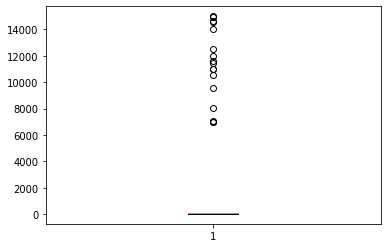

In [86]:
mc = df2.select("MonthlyCharges").rdd.flatMap(lambda x: x).collect()
plt.boxplot(mc)

{'boxes': [<matplotlib.lines.Line2D at 0x7f634db90410>],
 'caps': [<matplotlib.lines.Line2D at 0x7f634db97410>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f634db9e450>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f634db97ed0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f634db90950>,
  <matplotlib.lines.Line2D at 0x7f634db90e90>]}

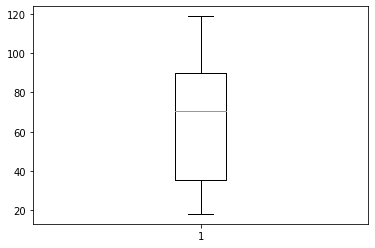

In [87]:
df2=df2.where("MonthlyCharges<6000")
#df1=df1.where("MonthlyCharges<6000")

mc = df2.select("MonthlyCharges").rdd.flatMap(lambda x: x).collect()
plt.boxplot(mc)

In [88]:
#df1=df1.where("MonthlyCharges<6000")


In [89]:
df2.stat.corr('MonthlyCharges', 'Label')

0.19356868699444624

# کورلیشن قابل توجهی دارد و فیچر موثری است

# 18.TotalCharges 

{'boxes': [<matplotlib.lines.Line2D at 0x7f634da7e150>],
 'caps': [<matplotlib.lines.Line2D at 0x7f634da05190>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f634da0d1d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f634da05c50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f634da7e6d0>,
  <matplotlib.lines.Line2D at 0x7f634da7ec10>]}

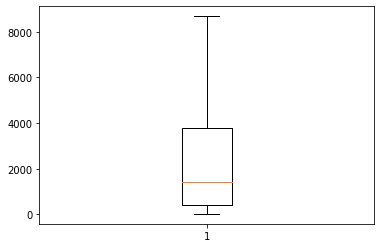

In [90]:
tc = df2.select("TotalCharges").rdd.flatMap(lambda x: x).collect()
plt.boxplot(tc)

In [91]:
df2.stat.corr('TotalCharges', 'Label')

-0.19947378365544852

In [92]:
df2.stat.corr('TotalCharges', 'MonthlyCharges')

0.6509708422184747

# کورلیشن بالایی با پرداختی ماهیانه دارد و لذا این فیچر را در نظر نمیگیریم چون هم اثر آن بر لیبل کم است هم اثر آن در پرداخت ماهیانه لحاظ نیز میشود

In [93]:
pruned_df2=df2.drop("gender","customerID")
pruned_df2.show()

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label| id|
+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+
|            0|      1|         1|  69.0|           1|            1|              1|             1|           1|               1|          1|          1|              1|       2|               0|            0|        113.25|     7895.15|    0|  0|
|       

# آی دی  موثر نیست ولی چون کلید اصلی است نگهداری میشود




# از جدول بالا برای آموزش در پیش بینی داده های گم شده استفاده میکنیم

In [94]:
pruned_df2.printSchema()

root
 |-- SeniorCitizen: integer (nullable = false)
 |-- Partner: integer (nullable = false)
 |-- Dependents: integer (nullable = false)
 |-- tenure: double (nullable = true)
 |-- PhoneService: integer (nullable = false)
 |-- MultipleLines: integer (nullable = false)
 |-- InternetService: integer (nullable = false)
 |-- OnlineSecurity: integer (nullable = false)
 |-- OnlineBackup: integer (nullable = false)
 |-- DeviceProtection: integer (nullable = false)
 |-- TechSupport: integer (nullable = false)
 |-- StreamingTV: integer (nullable = false)
 |-- StreamingMovies: integer (nullable = false)
 |-- Contract: integer (nullable = false)
 |-- PaperlessBilling: integer (nullable = false)
 |-- PaymentMethod: integer (nullable = false)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Label: integer (nullable = false)
 |-- id: long (nullable = false)



In [95]:
df1=df1.drop("gender",'customerID')
df1.show()

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label| id|
+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+
|            0|      1|         1|  70.0|           1|            1|              1|             1|           1|               1|          1|          0|              0|       2|               0|            3|          93.9|     6579.05|    1|  0|
|       

In [96]:
df1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df1.columns]
   ).show()

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label| id|
+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+
|          266|    225|       242|   225|         269|          263|            230|           230|         243|             254|        264|        249|            219|     230|             257|          246|           243|         251|  208|  0|
+-------

In [97]:
df1=df1.dropna(thresh=16)

In [98]:
df.count()

7038

# predicting missing values


## 1.SeniorCitizen

In [99]:
hasher1 = FeatureHasher(inputCols=["Partner", "Dependents","tenure",'PhoneService', "MultipleLines", "InternetService","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges","TotalCharges","Label"],
                       outputCol="features")

featurized1 = hasher1.transform(pruned_df2)
#featurized1=featurized1["SeniorCitizen","features"]
featurized1["SeniorCitizen","features"].show(truncate=False)

+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|features                                                                                                                                                                                             |
+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0            |(262144,[2933,7780,20762,44395,49795,61949,78347,91955,106258,138725,143274,144106,155996,211648,218458,229503,246667],[1.0,1.0,113.25,0.0,0.0,1.0,1.0,1.0,1.0,1.0,69.0,1.0,1.0,1.0,2.0,1.0,7895.15])|
|0            |(262144,[2933,7780,20762,44395,49795,61949,78347,91955,106258,138725,143274,144106,155996,211648,218458,229503,246667],[0.0,1.0,1

In [100]:
test1=df1.filter(df1["SeniorCitizen"].isNull())


test1 = hasher1.transform(test1)
#test1=test1["SeniorCitizen","features"]
test1["SeniorCitizen","features"].show(truncate=False)

+-------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|features                                                                                                                                                                                |
+-------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|null         |(262144,[2933,7780,20762,44395,49795,61949,78347,91955,106258,138725,144106,155996,211648,218458,229503,246667],[1.0,1.0,88.95,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,3027.65])|
|null         |(262144,[2933,7780,44395,49795,61949,78347,91955,138725,143274,144106,155996,211648,218458,229503],[2.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,71.0,2.0,1.0,1.0,1.0,1.0])                       

In [101]:
lr = LogisticRegression(featuresCol="features", labelCol="SeniorCitizen",maxIter=100,regParam=0.01)
model1=lr.fit(featurized1)

In [102]:
predictions1=model1.transform(test1)
predictions1.show(50)

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+----+--------------------+--------------------+--------------------+----------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|  id|            features|       rawPrediction|         probability|prediction|
+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+----+--------------------+--------------------+--------------------+----------+
|         null|      0|        

## 2.Partner

In [103]:
hasher2 = FeatureHasher(inputCols=["SeniorCitizen","TotalCharges", "Dependents","tenure",'PhoneService', "MultipleLines", "InternetService","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges","TotalCharges","Label"],
                       outputCol="features")
featurized2 = hasher2.transform(pruned_df2)
#featurized2=featurized2["Partner","features"]
featurized2.show(truncate=False)

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                                                                             |
+-------------+-------+----------+------+------------+-------------+---------------+--------------+---------

In [104]:
test2=df1.filter(df1["Partner"].isNull())
test2 = hasher2.transform(test2)
#test2=test2["Partner","features"]
test2["Partner","features"].show(truncate=False)
lr = LogisticRegression(featuresCol="features", labelCol="Partner",maxIter=100,regParam=0.01)
model2=lr.fit(featurized2)
predictions2=model2.transform(test2)
predictions2.show(50)

+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Partner|features                                                                                                                                                                                            |
+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|null   |(262144,[2933,7780,44395,49795,61949,78347,91955,138725,143274,144106,211648,222701,229503,246667],[1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,56.0,1.0,1.0,0.0,0.0,5515.45])                                  |
|null   |(262144,[2933,7780,44395,49795,61949,78347,91955,138725,143274,144106,155996,211648,218458,229503],[2.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,71.0,2.0,1.0,1.0,1.0,1.0])     

## 3.Dependents

In [105]:
hasher3 = FeatureHasher(inputCols=["SeniorCitizen","TotalCharges", "Partner","tenure",'PhoneService', "MultipleLines", "InternetService","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges","Label"],
                       outputCol="features")
featurized3 = hasher3.transform(pruned_df2)
#featurized3=featurized3["Dependents","features"]
featurized3.show(truncate=False)

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                                                                              |
+-------------+-------+----------+------+------------+-------------+---------------+--------------+-------

In [106]:
test3=df1.filter(df1["Dependents"].isNull())
test3 = hasher3.transform(test3)
#test3=test3["Dependents","features"]
test3["Dependents","features"].show(truncate=False)

lr = LogisticRegression(featuresCol="features", labelCol="Dependents",maxIter=100,regParam=0.01)
model3=lr.fit(featurized3)

predictions3=model3.transform(test3)
predictions3.show(50)

+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Dependents|features                                                                                                                                                                              |
+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|null      |(262144,[2933,20762,44395,61949,78347,106258,138725,143274,144106,155996,211648,218458,222701,229503,246667],[0.0,20.85,0.0,2.0,2.0,1.0,2.0,4.0,0.0,2.0,2.0,0.0,0.0,2.0,62.9])        |
|null      |(262144,[2933,20762,44395,61949,78347,106258,138725,143274,144106,155996,211648,218458,222701,229503],[0.0,25.7,0.0,2.0,2.0,0.0,2.0,43.0,1.0,2.0,2.0,2.0,0.0,2.0])                    |
|null      |(262144,

## 4.tenure

In [107]:
hasher4 = FeatureHasher(inputCols=["SeniorCitizen", "Partner",'PhoneService',"InternetService", "Dependents","MultipleLines" ,"OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges","TotalCharges","Label"],
                       outputCol="features")
featurized4 = hasher4.transform(pruned_df2)
#featurized4=featurized4["tenure","features"]
featurized4.show(truncate=False)

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                                                                            |
+-------------+-------+----------+------+------------+-------------+---------------+--------------+-----------

In [108]:
from pyspark.ml.regression import LinearRegression
test4=df1.filter(df1["tenure"].isNull())

test4 = hasher4.transform(test4)
#test4=test4["tenure","features"]
test4["tenure","features"].show(truncate=False)

lr = LinearRegression(featuresCol="features", labelCol="tenure",maxIter=100,regParam=0.01)
model4=lr.fit(featurized4)

predictions4=model4.transform(test4)
predictions4.show(50)

+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tenure|features                                                                                                                                                                                          |
+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|null  |(262144,[2933,7780,20762,44395,49795,61949,78347,91955,106258,138725,144106,155996,211648,218458,229503,246667],[1.0,1.0,88.95,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,3027.65])          |
|null  |(262144,[2933,7780,20762,44395,61949,78347,91955,106258,138725,144106,155996,211648,229503,246667],[1.0,1.0,99.8,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,5515.45])              

## 5.MultipleLines

In [109]:
hasher5 = FeatureHasher(inputCols=["SeniorCitizen","TotalCharges", "Partner","tenure",'PhoneService', "Dependents", "InternetService","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges","Label"],
                       outputCol="features")
featurized5 = hasher5.transform(pruned_df2)
#featurized5=featurized5["MultipleLines","features"]
featurized5.show(truncate=False)

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                                                                             |
+-------------+-------+----------+------+------------+-------------+---------------+--------------+---------

In [110]:
test5=df1.filter(df1["MultipleLines"].isNull())
test5 = hasher5.transform(test5)
#test5=test5["MultipleLines","features"]
test5["MultipleLines","features"].show(truncate=False)

lr = LogisticRegression(featuresCol="features", labelCol="MultipleLines",maxIter=100,regParam=0.01)
model5=lr.fit(featurized5)

predictions5=model5.transform(test5)
predictions5.show(50)

+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|MultipleLines|features                                                                                                                                                                                 |
+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|null         |(262144,[2933,7780,20762,44395,49795,61949,78347,91955,106258,138725,143274,155996,211648,218458,222701,246667],[2.0,0.0,56.45,0.0,2.0,0.0,1.0,0.0,0.0,0.0,71.0,1.0,1.0,1.0,1.0,3985.35])|
|null         |(262144,[2933,7780,44395,49795,61949,91955,106258,138725,143274,155996,211648,218458,222701,229503,246667],[0.0,1.0,0.0,3.0,2.0,0.0,1.0,2.0,72.0,2.0,2.0,2.0,0.0,2.0,1723.95])   

## 6.InternetService

In [111]:
hasher6 = FeatureHasher(inputCols=["SeniorCitizen","TotalCharges", "Partner","tenure",'PhoneService', "Dependents","MultipleLines" ,"OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges","Label"],
                       outputCol="features")
featurized6 = hasher6.transform(pruned_df2)
#featurized6=featurized6["InternetService","features"]
featurized6.show(truncate=False)

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                                                                               |
+-------------+-------+----------+------+------------+-------------+---------------+--------------+-----

In [112]:
test6=df1.filter(df1["InternetService"].isNull())
test6 = hasher6.transform(test6)
#test6=test6["InternetService","features"]
test6["InternetService","features"].show(truncate=False)

lr = LogisticRegression(featuresCol="features", labelCol="InternetService",maxIter=100,regParam=0.01)
model6=lr.fit(featurized6)

predictions6=model6.transform(test6)
predictions6.show(50)

+---------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|InternetService|features                                                                                                                                                                                   |
+---------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|null           |(262144,[7780,20762,49795,61949,78347,91955,106258,138725,143274,144106,155996,211648,218458,222701,229503,246667],[1.0,20.65,1.0,2.0,2.0,0.0,0.0,2.0,41.0,0.0,2.0,2.0,2.0,0.0,2.0,835.15])|
|null           |(262144,[7780,20762,44395,78347,91955,106258,138725,143274,144106,155996,211648,218458,229503,246667],[1.0,78.05,1.0,0.0,0.0,0.0,1.0,27.0,1.0,0.0,0.0,0.0,0.0,2

## 7.OnlineSecurity

In [113]:
hasher7 = FeatureHasher(inputCols=["SeniorCitizen","TotalCharges", "Partner","tenure",'PhoneService', "Dependents","MultipleLines" ,"InternetService", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges","Label"],
                       outputCol="features")
featurized7 = hasher7.transform(pruned_df2)
#featurized7=featurized7["OnlineSecurity","features"]
featurized7.show(truncate=False)

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                                                                             |
+-------------+-------+----------+------+------------+-------------+---------------+--------------+---------

In [114]:
test7=df1.filter(df1["OnlineSecurity"].isNull())
test7 = hasher7.transform(test7)
#test7=test7["OnlineSecurity","features"]
test7["OnlineSecurity","features"].show(truncate=False)

lr = LogisticRegression(featuresCol="features", labelCol="OnlineSecurity",maxIter=100,regParam=0.01)
model7=lr.fit(featurized7)

predictions7=model7.transform(test7)
predictions7.show(50)

+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|OnlineSecurity|features                                                                                                                                                                                            |
+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|null          |(262144,[2933,7780,20762,44395,49795,61949,78347,91955,106258,138725,143274,155996,211648,218458,222701,246667],[2.0,0.0,56.45,0.0,2.0,0.0,1.0,0.0,0.0,0.0,71.0,1.0,1.0,1.0,1.0,3985.35])           |
|null          |(262144,[2933,7780,44395,49795,78347,91955,106258,138725,143274,144106,155996,211648,218458,222701,246667],[0.0,1.0,0.0,1.0,2.0,

## 8.OnlineBackup

In [115]:
hasher8 = FeatureHasher(inputCols=["SeniorCitizen","TotalCharges", "Partner","tenure",'PhoneService', "Dependents","MultipleLines" ,"InternetService", "OnlineSecurity", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges","Label"],
                       outputCol="features")
featurized8 = hasher8.transform(pruned_df2)
#featurized8=featurized8["OnlineBackup","features"]
featurized8.show(truncate=False)

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                                                                              |
+-------------+-------+----------+------+------------+-------------+---------------+--------------+-------

In [116]:
test8=df1.filter(df1["OnlineBackup"].isNull())
test8 = hasher8.transform(test8)
#test8=test8["OnlineBackup","features"]
test8["OnlineBackup","features"].show(truncate=False)

lr = LogisticRegression(featuresCol="features", labelCol="OnlineBackup",maxIter=100,regParam=0.01)
model8=lr.fit(featurized8)

predictions8=model8.transform(test8)
predictions8.show(50)

+------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|OnlineBackup|features                                                                                                                                                                                 |
+------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|null        |(262144,[2933,7780,44395,49795,61949,91955,106258,138725,143274,155996,211648,218458,222701,229503,246667],[0.0,1.0,0.0,3.0,2.0,0.0,1.0,2.0,72.0,2.0,2.0,2.0,0.0,2.0,1723.95])           |
|null        |(262144,[2933,7780,44395,49795,61949,91955,106258,138725,143274,155996,211648,218458,222701,229503,246667],[1.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,33.0,1.0,0.0,2.0,0.0,1.0,3027.65])        

## 9.DeviceProtection

In [117]:
hasher9 = FeatureHasher(inputCols=["SeniorCitizen","TotalCharges", "Partner","tenure",'PhoneService', "Dependents","MultipleLines" ,"InternetService", "OnlineBackup","OnlineSecurity" , "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges","Label"],
                       outputCol="features")
featurized9 = hasher9.transform(pruned_df2)
#featurized9=featurized9["DeviceProtection","features"]
featurized9.show(truncate=False)

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                                                                             |
+-------------+-------+----------+------+------------+-------------+---------------+--------------+---------

In [118]:
test9=df1.filter(df1["DeviceProtection"].isNull())
test9 = hasher9.transform(test9)
#test9=test9["DeviceProtection","features"]
test9["DeviceProtection","features"].show(truncate=False)

lr = LogisticRegression(featuresCol="features", labelCol="DeviceProtection",maxIter=100,regParam=0.01)
model9=lr.fit(featurized9)

predictions9=model9.transform(test9)
predictions9.show(50)

+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|DeviceProtection|features                                                                                                                                                                                           |
+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|null            |(262144,[7780,20762,44395,49795,61949,91955,106258,143274,144106,155996,211648,222701,229503,246667],[1.0,23.55,0.0,3.0,2.0,0.0,1.0,72.0,1.0,2.0,2.0,0.0,2.0,1723.95])                             |
|null            |(262144,[7780,20762,44395,49795,61949,91955,106258,143274,155996,211648,218458,222701,229503,246667],[1.0,50.7,0.0,1.0,0.0

## 10.TechSupport

In [119]:
hasher10 = FeatureHasher(inputCols=["SeniorCitizen","TotalCharges", "Partner","tenure", 'PhoneService',"Dependents","MultipleLines" ,"InternetService", "OnlineBackup","OnlineSecurity" ,"DeviceProtection" , "StreamingTV", "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges","Label"],
                       outputCol="features")
featurized10 = hasher10.transform(pruned_df2)
#featurized10=featurized10["TechSupport","features"]
featurized10.show(truncate=False)

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                                                                              |
+-------------+-------+----------+------+------------+-------------+---------------+--------------+-------

In [120]:
test10=df1.filter(df1["TechSupport"].isNull())
test10 = hasher10.transform(test10)
#test10=test10["TechSupport","features"]
test10["TechSupport","features"].show(truncate=False)

lr = LogisticRegression(featuresCol="features", labelCol="TechSupport",maxIter=100,regParam=0.01)
model10=lr.fit(featurized10)

predictions10=model10.transform(test10)
predictions10.show(50)

+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|TechSupport|features                                                                                                                                                                         |
+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|null       |(262144,[7780,20762,44395,78347,91955,106258,138725,143274,144106,155996,211648,218458,229503,246667],[1.0,78.05,1.0,0.0,0.0,0.0,1.0,27.0,1.0,0.0,0.0,0.0,0.0,2135.5])           |
|null       |(262144,[2933,20762,44395,49795,78347,91955,138725,143274,144106,155996,211648,218458,222701,229503,246667],[0.0,19.6,0.0,1.0,2.0,1.0,2.0,57.0,0.0,2.0,2.0,2.0,0.0,2.0,1170.55]) |
|null       |(262144,[2933,7780,44395,49

## 11.StreamingTV

In [121]:
hasher11 = FeatureHasher(inputCols=["SeniorCitizen","TotalCharges", "Partner","tenure",'PhoneService', "Dependents","MultipleLines" ,"InternetService", "OnlineBackup","OnlineSecurity" ,"DeviceProtection" ,"TechSupport" , "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges","Label"],
                       outputCol="features")
featurized11 = hasher11.transform(pruned_df2)
#featurized11=featurized11["StreamingTV","features"]
featurized11.show(truncate=False)

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                                                                             |
+-------------+-------+----------+------+------------+-------------+---------------+--------------+---------

In [122]:
test11=df1.filter(df1["StreamingTV"].isNull())
test11 = hasher11.transform(test11)
#test11=test11["StreamingTV","features"]
test11["StreamingTV","features"].show(truncate=False)

lr = LogisticRegression(featuresCol="features", labelCol="StreamingTV",maxIter=100,regParam=0.01)
model11=lr.fit(featurized11)

predictions11=model11.transform(test11)
predictions11.show(50)

+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|StreamingTV|features                                                                                                                                                                       |
+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|null       |(262144,[2933,7780,44395,49795,61949,78347,91955,138725,143274,144106,211648,222701,229503,246667],[1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,56.0,1.0,1.0,0.0,0.0,5515.45])             |
|null       |(262144,[2933,7780,20762,44395,49795,61949,78347,91955,138725,144106,211648,222701,229503,246667],[2.0,0.0,54.6,0.0,2.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,3423.5])               |
|null       |(262144,[2933,7780,20762,49795,61949,

## 12.StreamingMovies

In [123]:
hasher12 = FeatureHasher(inputCols=["SeniorCitizen","TotalCharges", "Partner","tenure", 'PhoneService',"Dependents","MultipleLines" ,"InternetService", "OnlineBackup","OnlineSecurity" ,"DeviceProtection" ,"TechSupport" , "StreamingTV", "Contract","PaymentMethod", "MonthlyCharges","Label"],
                       outputCol="features")
featurized12 = hasher12.transform(pruned_df2)
#featurized12=featurized12["StreamingMovies","features"]
featurized12.show(truncate=False)

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                                                                             |
+-------------+-------+----------+------+------------+-------------+---------------+--------------+---------

In [124]:
test12=df1.filter(df1["StreamingMovies"].isNull())
test12 = hasher12.transform(test12)
#test12=test12["StreamingMovies","features"]
test12["StreamingMovies","features"].show(truncate=False)

lr = LogisticRegression(featuresCol="features", labelCol="StreamingMovies",maxIter=100,regParam=0.01)
model12=lr.fit(featurized12)

predictions12=model12.transform(test12)
predictions12.show(50)

+---------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|StreamingMovies|features                                                                                                                                                                                |
+---------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|null           |(262144,[7780,20762,44395,49795,61949,78347,91955,138725,143274,144106,155996,222701,229503,246667],[1.0,19.6,0.0,1.0,2.0,2.0,1.0,2.0,57.0,0.0,2.0,0.0,2.0,1170.55])                    |
|null           |(262144,[2933,7780,20762,44395,61949,78347,138725,143274,144106,155996,218458,222701,229503,246667],[0.0,1.0,23.55,0.0,2.0,2.0,2.0,72.0,1.0,2.0,2.0,0.0,2.0,1723.95])      

## 13.Contract

In [125]:
hasher13 = FeatureHasher(inputCols=["SeniorCitizen","TotalCharges", "Partner","tenure",'PhoneService', "Dependents","MultipleLines" ,"InternetService", "OnlineBackup","OnlineSecurity" ,"DeviceProtection" ,"TechSupport" , "StreamingTV", "StreamingMovies","PaymentMethod", "MonthlyCharges","Label"],
                       outputCol="features")
featurized13 = hasher13.transform(pruned_df2)
#featurized13=featurized13["Contract","features"]
featurized13.show(truncate=False)

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                                                                             |
+-------------+-------+----------+------+------------+-------------+---------------+--------------+---------

In [126]:
test13=df1.filter(df1["Contract"].isNull())
test13 = hasher13.transform(test13)
#test13=test13["Contract","features"]
test13["Contract","features"].show(truncate=False)

lr = LogisticRegression(featuresCol="features", labelCol="Contract",maxIter=100,regParam=0.01)
model13=lr.fit(featurized13)

predictions13=model13.transform(test13)
predictions13.show(50)

+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Contract|features                                                                                                                                                                                |
+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|null    |(262144,[2933,7780,44395,49795,61949,78347,91955,138725,143274,144106,211648,222701,229503,246667],[1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,56.0,1.0,1.0,0.0,0.0,5515.45])                      |
|null    |(262144,[2933,7780,20762,44395,61949,78347,91955,106258,138725,144106,155996,211648,229503,246667],[1.0,1.0,99.8,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,5515.45])                      |
|null    |(262144,[7

## 14.PaymentMethod

In [127]:
hasher14 = FeatureHasher(inputCols=["SeniorCitizen","TotalCharges", "Partner","tenure",'PhoneService', "Dependents","MultipleLines" ,"InternetService", "OnlineBackup","OnlineSecurity" ,"DeviceProtection" ,"TechSupport" , "StreamingTV", "StreamingMovies","Contract", "MonthlyCharges","Label"],
                       outputCol="features")
featurized14 = hasher14.transform(pruned_df2)
#featurized14=featurized14["PaymentMethod","features"]
featurized14.show(truncate=False)

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                                                                              |
+-------------+-------+----------+------+------------+-------------+---------------+--------------+-------

In [128]:

test14=df1.filter(df1["PaymentMethod"].isNull())
test14 = hasher14.transform(test14)
#test14=test14["PaymentMethod","features"]
test14["PaymentMethod","features"].show(truncate=False)

lr = LogisticRegression(featuresCol="features", labelCol="PaymentMethod",maxIter=100,regParam=0.01)
model14=lr.fit(featurized14)

predictions14=model14.transform(test14)
predictions14.show(50)

+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|PaymentMethod|features                                                                                                                                                                                     |
+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|null         |(262144,[2933,20762,44395,61949,78347,106258,138725,143274,144106,155996,211648,218458,222701,229503,246667],[0.0,20.85,0.0,2.0,2.0,1.0,2.0,4.0,0.0,2.0,2.0,0.0,0.0,2.0,62.9])               |
|null         |(262144,[7780,20762,44395,78347,91955,106258,138725,143274,144106,155996,211648,218458,229503,246667],[1.0,78.05,1.0,0.0,0.0,0.0,1.0,27.0,1.0,0.0,0.0,0.0,0.0,213

## 15.MonthlyCharges

In [129]:
hasher15 = FeatureHasher(inputCols=["SeniorCitizen","TotalCharges", "Partner","tenure",'PhoneService', "Dependents","MultipleLines" ,"InternetService", "OnlineBackup","OnlineSecurity" ,"DeviceProtection" ,"TechSupport" , "StreamingTV", "StreamingMovies","Contract","PaymentMethod" ,"Label"],
                       outputCol="features")
featurized15 = hasher15.transform(pruned_df2)
#featurized15=featurized15["MonthlyCharges","features"]
featurized15.show(truncate=False)

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                                                                           |
+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+

In [130]:
from pyspark.ml.regression import LinearRegression
test15=df1.filter(df1["MonthlyCharges"].isNull())

test15 = hasher15.transform(test15)
#test15=test15["MonthlyCharges","features"]
test15["MonthlyCharges","features"].show(truncate=False)

lr = LinearRegression(featuresCol="features", labelCol="MonthlyCharges",maxIter=100,regParam=0.01)
model15=lr.fit(featurized15)

predictions15=model15.transform(test15)
predictions15.show(50)

+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|MonthlyCharges|features                                                                                                                                                                                |
+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|null          |(262144,[2933,7780,44395,49795,61949,91955,106258,138725,143274,155996,211648,218458,222701,229503,246667],[0.0,1.0,0.0,3.0,2.0,0.0,1.0,2.0,72.0,2.0,2.0,2.0,0.0,2.0,1723.95])          |
|null          |(262144,[2933,7780,44395,49795,61949,91955,106258,138725,143274,155996,211648,218458,222701,229503,246667],[1.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,33.0,1.0,0.0,2.0,0.0,1.0,3027.65])  

In [131]:
from pyspark.ml.regression import LinearRegression
reg=LinearRegression(maxIter=10, regParam=0.03) # as an estimator
reg.explainParams()

'aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)\nepsilon: The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)\nfeaturesCol: features column name. (default: features)\nfitIntercept: whether to fit an intercept term. (default: True)\nlabelCol: label column name. (default: label)\nloss: The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)\nmaxBlockSizeInMB: maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0. (default: 0.0)\nmaxIter: max number of iterations (>= 0). (default: 10

In [132]:
df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+---+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label| id|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+---+
|3655-SNQYZ|Female|          0.0|    Yes|       Y

In [133]:
df2.count()

7006

In [134]:
df2.groupBy('customerID','gender','SeniorCitizen','Partner','Dependents','tenure','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges','Label').count().sort(col("count").desc()).show(50)


+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|count|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+-----+
|0285-INHLN|  Male|            0|      1|         1|  27.0|           1|            0|              2|             1|           1|               0|          0|          0|              0|       0|

In [135]:
df2.groupBy('customerID').count().sort(col("count").desc()).show(50)


+------------+-----+
|  customerID|count|
+------------+-----+
|  3692-JHONH|    1|
|  3528-HFRIQ|    1|
|  2011-TRQYE|    1|
|  3195-TQDZX|    1|
|  0786-VSSUD|    1|
|  7661-CPURM|    1|
|  6718-BDGHG|    1|
|5386-THSLQcs|    1|
|  5802-ADBRC|    1|
|  1894-IGFSG|    1|
|  4868-AADLV|    1|
|  3668-QPYBK|    1|
|  0953-LGOVU|    1|
|  0356-ERHVT|    1|
|  0117-LFRMW|    1|
|  2712-SYWAY|    1|
|  6383-ZTSIW|    1|
|  3623-FQBOX|    1|
|  6479-OAUSD|    1|
|  4248-QPAVC|    1|
|  5859-HZYLF|    1|
|  5668-MEISB|    1|
|  9921-QFQUL|    1|
|  1450-SKCVI|    1|
|  7244-KXYZN|    1|
|  6982-SSHFK|    1|
|  2592-YKDIF|    1|
|  1229-RCALF|    1|
|  6481-OGDOO|    1|
|  5183-SNMJQ|    1|
|  5126-RCXYW|    1|
|  8265-HKSOW|    1|
|  7318-EIVKO|    1|
|  8652-YHIYU|    1|
|  2034-CGRHZ|    1|
|  7740-BTPUX|    1|
|  1241-EZFMJ|    1|
|  2676-SSLTO|    1|
|  6092-QZVPP|    1|
|  6917-YACBP|    1|
|  0734-OXWBT|    1|
|  5288-AHOUP|    1|
|  0315-LVCRK|    1|
|  8873-TMKGR|    1|
|  8268-YDIXR

In [136]:
from pyspark.sql.functions import coalesce
predictions1=predictions1.withColumn('SeniorCitizen', coalesce('SeniorCitizen', 'prediction'))
predictions1=predictions1['id','SeniorCitizen']
predictions1=predictions1.withColumnRenamed("SeniorCitizen","SeniorCitizen1")

predictions2=predictions2.withColumn('Partner', coalesce('Partner', 'prediction'))
predictions2=predictions2['id','Partner']
predictions2=predictions2.withColumnRenamed("Partner","Partner1")

predictions3=predictions3.withColumn('Dependents', coalesce('Dependents', 'prediction'))
predictions3=predictions3['id','Dependents']
predictions3=predictions3.withColumnRenamed("Dependents","Dependents1")

predictions4=predictions4.withColumn('tenure', coalesce('tenure', 'prediction'))
predictions4=predictions4['id','tenure']
predictions4=predictions4.withColumnRenamed("tenure","tenure1")

predictions5=predictions5.withColumn('MultipleLines', coalesce('MultipleLines', 'prediction'))
predictions5=predictions5['id','MultipleLines']
predictions5=predictions5.withColumnRenamed("MultipleLines","MultipleLines1")

predictions6=predictions6.withColumn('InternetService', coalesce('InternetService', 'prediction'))
predictions6=predictions6['id','InternetService']
predictions6=predictions6.withColumnRenamed("InternetService","InternetService1")

predictions7=predictions7.withColumn('OnlineSecurity', coalesce('OnlineSecurity', 'prediction'))
predictions7=predictions7['id','OnlineSecurity']
predictions7=predictions7.withColumnRenamed("OnlineSecurity","OnlineSecurity1")

predictions8=predictions8.withColumn('OnlineBackup', coalesce('OnlineBackup', 'prediction'))
predictions8=predictions8['id','OnlineBackup']
predictions8=predictions8.withColumnRenamed("OnlineBackup","OnlineBackup1")

predictions9=predictions9.withColumn('DeviceProtection', coalesce('DeviceProtection', 'prediction'))
predictions9=predictions9['id','DeviceProtection']
predictions9=predictions9.withColumnRenamed("DeviceProtection","DeviceProtection1")

predictions10=predictions10.withColumn('TechSupport', coalesce('TechSupport', 'prediction'))
predictions10=predictions10['id','TechSupport']
predictions10=predictions10.withColumnRenamed("TechSupport","TechSupport1")

predictions11=predictions11.withColumn('StreamingTV', coalesce('StreamingTV', 'prediction'))
predictions11=predictions11['id','StreamingTV']
predictions11=predictions11.withColumnRenamed("StreamingTV","StreamingTV1")

predictions12=predictions12.withColumn('StreamingMovies', coalesce('StreamingMovies', 'prediction'))
predictions12=predictions12['id','StreamingMovies']
predictions12=predictions12.withColumnRenamed("StreamingMovies","StreamingMovies1")

predictions13=predictions13.withColumn('Contract', coalesce('Contract', 'prediction'))
predictions13=predictions13['id','Contract']
predictions13=predictions13.withColumnRenamed("Contract","Contract1")

predictions14=predictions14.withColumn('PaymentMethod', coalesce('PaymentMethod', 'prediction'))
predictions14=predictions14['id','PaymentMethod']
predictions14=predictions14.withColumnRenamed("PaymentMethod","PaymentMethod1")

predictions15=predictions15.withColumn('MonthlyCharges', coalesce('MonthlyCharges', 'prediction'))
predictions15=predictions15['id','MonthlyCharges']
predictions15=predictions15.withColumnRenamed("MonthlyCharges","MonthlyCharges1")

In [137]:
#from pyspark.sql.functions import *
#predictions15=predictions15.withColumn("MonthlyCharges", regexp_replace('Source_ids', '\..*$', ''))
#predictions4=predictions4.withColumn("tenure", regexp_replace('Source_ids', '\..*$', ''))

# filling missing values with predicted ones

## همانطور که دیده میشود ستون زیر در پیش بینی ها از قلم افتاده است
paperlessbilling

In [138]:
hasher16 = FeatureHasher(inputCols=["SeniorCitizen","TotalCharges", "Partner","tenure",'PhoneService', "Dependents","MultipleLines" ,"InternetService", "OnlineBackup","OnlineSecurity" ,"DeviceProtection" ,"TechSupport" , "StreamingTV", "StreamingMovies","Contract","PaymentMethod", "MonthlyCharges","Label"],
                       outputCol="features")
featurized16 = hasher16.transform(pruned_df2)
featurized16.show(truncate=False)
test16=df1.filter(df1["PaperlessBilling"].isNull())
test16 = hasher16.transform(test16)
test16["PaperlessBilling","features"].show(truncate=False)

lr = LogisticRegression(featuresCol="features", labelCol="PaperlessBilling",maxIter=100,regParam=0.01)
model16=lr.fit(featurized16)

predictions16=model16.transform(test16)
predictions16.show(50)

predictions16=predictions16.withColumn('PaperlessBilling', coalesce('PaperlessBilling', 'prediction'))
predictions16=predictions16['id','PaperlessBilling']
predictions16=predictions16.withColumnRenamed("PaperlessBilling","PaperlessBilling1")



+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                                                                                        |
+-------------+-------+----------+------+------------+-------------+---------------+--

In [139]:
hasher17 = FeatureHasher(inputCols=["SeniorCitizen","TotalCharges", "Partner","tenure",'PaperlessBilling', "Dependents","MultipleLines" ,"InternetService", "OnlineBackup","OnlineSecurity" ,"DeviceProtection" ,"TechSupport" , "StreamingTV", "StreamingMovies","Contract","PaymentMethod", "MonthlyCharges","Label"],
                       outputCol="features")
featurized17 = hasher17.transform(pruned_df2)
featurized17.show(truncate=False)
test17=df1.filter(df1["PhoneService"].isNull())
test17 = hasher17.transform(test17)
test17["PhoneService","features"].show(truncate=False)

lr = LogisticRegression(featuresCol="features", labelCol="PhoneService",maxIter=100,regParam=0.01)
model17=lr.fit(featurized17)

predictions17=model17.transform(test17)
predictions17.show()

predictions17=predictions17.withColumn('PhoneService', coalesce('PhoneService', 'prediction'))
predictions17=predictions17['id','PhoneService']
predictions17=predictions17.withColumnRenamed("PhoneService","PhoneService1")



+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                                                                                          |
+-------------+-------+----------+------+------------+-------------+--------------

In [140]:
hasher18 = FeatureHasher(inputCols=["SeniorCitizen", "Partner","tenure",'PaperlessBilling', "Dependents","MultipleLines" ,"InternetService", "OnlineBackup","OnlineSecurity" ,"DeviceProtection" ,"TechSupport" , "StreamingTV", "StreamingMovies","Contract","PaymentMethod", "MonthlyCharges","Label"],
                       outputCol="features")
featurized18 = hasher18.transform(pruned_df2)
featurized18.show(truncate=False)
test18=df1.filter(df1["TotalCharges"].isNull())
test18 = hasher18.transform(test18)
test18["TotalCharges","features"].show(truncate=False)

lr = LinearRegression(featuresCol="features", labelCol="TotalCharges",maxIter=100,regParam=0.01)
model18=lr.fit(featurized18)

predictions18=model18.transform(test18)
predictions18.show()

predictions18=predictions18.withColumn('TotalCharges', coalesce('TotalCharges', 'prediction'))
predictions18=predictions18['id','TotalCharges']
predictions18=predictions18.withColumnRenamed("TotalCharges","TotalCharges1")



+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|id |features                                                                                                                                                                                           |
+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+

In [141]:
DF = df1.join(predictions1, "id", how='left')
DF=DF.withColumn('SeniorCitizen', coalesce('SeniorCitizen', 'SeniorCitizen1'))
DF=DF.drop("SeniorCitizen1")

DF = DF.join(predictions2, "id", how='left')
DF=DF.withColumn('Partner', coalesce('Partner', 'Partner1'))
DF=DF.drop("Partner1")

DF = DF.join(predictions3, "id", how='left')
DF=DF.withColumn('Dependents', coalesce('Dependents', 'Dependents1'))
DF=DF.drop("Dependents1")

DF = DF.join(predictions4, "id", how='left')
DF=DF.withColumn('tenure', coalesce('tenure', 'tenure1'))
DF=DF.drop("tenure1")


DF = DF.join(predictions5, "id", how='left')
DF=DF.withColumn('MultipleLines', coalesce('MultipleLines', 'MultipleLines1'))
DF=DF.drop("MultipleLines1")


DF = DF.join(predictions6, "id", how='left')
DF=DF.withColumn('InternetService', coalesce('InternetService', 'InternetService1'))
DF=DF.drop("InternetService1")


DF = DF.join(predictions7, "id", how='left')
DF=DF.withColumn('OnlineSecurity', coalesce('OnlineSecurity', 'OnlineSecurity1'))
DF=DF.drop("OnlineSecurity1")


DF = DF.join(predictions8, "id", how='left')
DF=DF.withColumn('OnlineBackup', coalesce('OnlineBackup', 'OnlineBackup1'))
DF=DF.drop("OnlineBackup1")


DF = DF.join(predictions9, "id", how='left')
DF=DF.withColumn('DeviceProtection', coalesce('DeviceProtection', 'DeviceProtection1'))
DF=DF.drop("DeviceProtection1")


DF = DF.join(predictions10, "id", how='left')
DF=DF.withColumn('TechSupport', coalesce('TechSupport', 'TechSupport1'))
DF=DF.drop("TechSupport1")


DF = DF.join(predictions11, "id", how='left')
DF=DF.withColumn('StreamingTV', coalesce('StreamingTV', 'StreamingTV1'))
DF=DF.drop("StreamingTV1")


DF = DF.join(predictions12, "id", how='left')
DF=DF.withColumn('StreamingMovies', coalesce('StreamingMovies', 'StreamingMovies1'))
DF=DF.drop("StreamingMovies1")


DF = DF.join(predictions13, "id", how='left')
DF=DF.withColumn('Contract', coalesce('Contract', 'Contract1'))
DF=DF.drop("Contract1")


DF = DF.join(predictions14, "id", how='left')
DF=DF.withColumn('PaymentMethod', coalesce('PaymentMethod', 'PaymentMethod1'))
DF=DF.drop("PaymentMethod1")


DF = DF.join(predictions15, "id", how='left')
DF=DF.withColumn('MonthlyCharges', coalesce('MonthlyCharges', 'MonthlyCharges1'))
DF=DF.drop("MonthlyCharges1")

DF = DF.join(predictions16, "id", how='left')
DF=DF.withColumn('PaperlessBilling', coalesce('PaperlessBilling', 'PaperlessBilling1'))
DF=DF.drop("PaperlessBilling1")

DF = DF.join(predictions17, "id", how='left')
DF=DF.withColumn('PhoneService', coalesce('PhoneService', 'PhoneService1'))
DF=DF.drop("PhoneService1")

DF = DF.join(predictions18, "id", how='left')
DF=DF.withColumn('TotalCharges', coalesce('TotalCharges', 'TotalCharges1'))
DF=DF.drop("TotalCharges1")

In [142]:
DF.show(5)

+---+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
| id|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+---+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|  0|          0.0|    1.0|       1.0|  70.0|         1.0|          1.0|            1.0|           1.0|         1.0|             1.0|        1.0|        0.0|            0.0|     2.0|             0.0|          3.0|          93.9|     6579.05|    1|
|  1|   

#splitting rows with missing values at label column

In [143]:
missing_labels=DF.filter(DF["Label"].isNull())
final_df=DF.na.drop(subset=["Label"]) 
missing_labels.show(5)
final_df.show(5)

+----+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------------+-----+
|  id|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|      TotalCharges|Label|
+----+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------------+-----+
| 323|          0.0|    0.0|       0.0|  41.0|         1.0|          0.0|            0.0|           2.0|         2.0|             2.0|        2.0|        2.0|            2.0|     2.0|             0.0|          1.0|         20.65|      

In [144]:
#missing_labels.count()

In [145]:
df = spark.read.csv('/content/gdrive/MyDrive/data.csv', header = True, inferSchema = True)
df=df.na.drop(subset=["Label"]) 
hasher = FeatureHasher(inputCols=["customerID","gender", "SeniorCitizen", "Partner", "Dependents","tenure", "PhoneService", "MultipleLines", "InternetService","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges", "TotalCharges", "TotalCharges"],
                       outputCol="features")

featurized = hasher.transform(df)
featurized=featurized.withColumn("Label", when(col("Label")=='Yes', 1).otherwise(0))

train, test = featurized.randomSplit(weights=[0.8,0.2], seed=200)
lr = LogisticRegression( labelCol="Label",maxIter=100,regParam=0.01)
model=lr.fit(train)
old_predictions=model.transform(test)
old_predictions.groupBy('Label', 'prediction').count().show()
TN = old_predictions.filter('prediction = 0 AND Label = prediction').count()
TP = old_predictions.filter('prediction = 1 AND Label = prediction').count()
FN = old_predictions.filter('prediction = 0 AND Label = 1').count()
FP = old_predictions.filter('prediction = 1 AND Label = 0').count()
old_accuracy = (TN + TP) / (TN + TP + FN + FP)
old_Precision = TP/(TP+FP)
old_Recall = TP/(TP+FN)
old_F_Measure=(2*old_Precision*old_Recall)/(old_Precision+old_Recall)


+-----+----------+-----+
|Label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  114|
|    0|       0.0|39233|
|    1|       1.0| 6618|
|    0|       1.0|    5|
+-----+----------+-----+



In [146]:
final_hasher = FeatureHasher(inputCols=[ "SeniorCitizen", "Partner", "Dependents","tenure",'PhoneService',  "MultipleLines", "InternetService","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges"],
                       outputCol="features")

featurized = final_hasher.transform(final_df)
final_train, final_test = featurized.randomSplit(weights=[0.8,0.2], seed=200)

featurized=featurized["Label","features"]
lr = LogisticRegression(featuresCol="features", labelCol="Label",maxIter=100,regParam=0.01)
final_model=lr.fit(final_train)
final_predictions=final_model.transform(final_test)
final_predictions.groupBy('Label', 'prediction').count().show()
TN = final_predictions.filter('prediction = 0 AND Label = prediction').count()
TP = final_predictions.filter('prediction = 1 AND Label = prediction').count()
FN = final_predictions.filter('prediction = 0 AND Label = 1').count()
FP = final_predictions.filter('prediction = 1 AND Label = 0').count()
final_accuracy = (TN + TP) / (TN + TP + FN + FP)
final_Precision = TP/(TP+FP)
final_Recall = TP/(TP+FN)
final_F_Measure=(2*final_Precision*final_Recall)/(final_Precision+final_Recall)
print('accuracy:',old_accuracy,'=>',new_accuracy,'=>',final_accuracy)
print("Precision:",old_Precision,'=>',new_Precision,'=>',final_Precision)
print("Recall:",old_Recall,'=>',new_Recall,'=>',final_Recall)
print("F_Measure:",old_F_Measure,'=>',new_F_Measure,'=>',final_F_Measure)


+-----+----------+-----+
|Label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  178|
|    0|       0.0| 1017|
|    1|       1.0|  181|
|    0|       1.0|   82|
+-----+----------+-----+

accuracy: 0.9974113552316728 => 0.791023842917251 => 0.821673525377229
Precision: 0.9992450551109769 => 0.6533333333333333 => 0.688212927756654
Recall: 0.9830659536541889 => 0.5025641025641026 => 0.5041782729805014
F_Measure: 0.9910894795956571 => 0.5681159420289855 => 0.5819935691318328


In [147]:
print("thresh is 16")
print('no preprocessing')
old_predictions.groupBy('Label', 'prediction').count().show()
print('just cleaning missin_values/dupilcates')
new_predictions.groupBy('Label', 'prediction').count().show()
print('completely preprocessed')
final_predictions.groupBy('Label', 'prediction').count().show()
print('accuracy:',old_accuracy,'=>',new_accuracy,'=>',final_accuracy)
print("Precision:",old_Precision,'=>',new_Precision,'=>',final_Precision)
print("Recall:",old_Recall,'=>',new_Recall,'=>',final_Recall)
print("F_Measure:",old_F_Measure,'=>',new_F_Measure,'=>',final_F_Measure)

thresh is 16
no preprocessing
+-----+----------+-----+
|Label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  114|
|    0|       0.0|39233|
|    1|       1.0| 6618|
|    0|       1.0|    5|
+-----+----------+-----+

just cleaning missin_values/dupilcates
+-----+----------+-----+
|Label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  194|
|    0|       0.0|  932|
|    1|       1.0|  196|
|    0|       1.0|  104|
+-----+----------+-----+

completely preprocessed
+-----+----------+-----+
|Label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  178|
|    0|       0.0| 1017|
|    1|       1.0|  181|
|    0|       1.0|   82|
+-----+----------+-----+

accuracy: 0.9974113552316728 => 0.791023842917251 => 0.821673525377229
Precision: 0.9992450551109769 => 0.6533333333333333 => 0.688212927756654
Recall: 0.9830659536541889 => 0.5025641025641026 => 0.5041782729805014
F_Measure: 0.9910894795956571 => 0.5681159420289855 => 0.5819935691318328


# considering PCA candidates

###### to see the candidates just search for candidate in the file

In [148]:
#pca_df=
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=["InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingTV"], outputCol=vector_col)
df_vector = assembler.transform(df2).select(vector_col)
df_vector.show(truncate=False)
# get correlation matrix
#matrix = Correlation.corr(df_vector, 'corr_features')

+-----------------------------+
|corr_features                |
+-----------------------------+
|[1.0,1.0,1.0,1.0,1.0,1.0,1.0]|
|[0.0,2.0,2.0,2.0,2.0,2.0,2.0]|
|(7,[0,2,3],[1.0,1.0,1.0])    |
|(7,[0,5,6],[2.0,1.0,1.0])    |
|[1.0,0.0,1.0,1.0,0.0,1.0,1.0]|
|[0.0,2.0,2.0,2.0,2.0,2.0,2.0]|
|[1.0,1.0,1.0,1.0,1.0,1.0,1.0]|
|[1.0,1.0,1.0,1.0,1.0,0.0,0.0]|
|(7,[0,2,3],[2.0,1.0,1.0])    |
|[1.0,1.0,1.0,1.0,1.0,1.0,1.0]|
|[0.0,2.0,2.0,2.0,2.0,2.0,2.0]|
|(7,[0,3],[1.0,1.0])          |
|(7,[0,1],[2.0,1.0])          |
|[2.0,1.0,1.0,1.0,1.0,1.0,1.0]|
|[1.0,0.0,1.0,1.0,0.0,1.0,1.0]|
|(7,[0,3],[2.0,1.0])          |
|[1.0,1.0,1.0,0.0,0.0,1.0,1.0]|
|[0.0,2.0,2.0,2.0,2.0,2.0,2.0]|
|(7,[0,3],[2.0,1.0])          |
|[2.0,1.0,0.0,1.0,0.0,1.0,1.0]|
+-----------------------------+
only showing top 20 rows



In [149]:
matrix = Correlation.corr(df_vector, 'corr_features')

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [150]:
pearsonCorr = Correlation.corr(df_vector, 'corr_features', 'pearson').collect()[0][0]

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [151]:
print(str(pearsonCorr).replace('nan', 'NaN'))


DenseMatrix([[ 1.        , -0.60754192, -0.65862147, -0.66252708, -0.6096789 ,
              -0.71266501, -0.71266501],
             [-0.60754192,  1.        ,  0.75094664,  0.74853115,  0.79114152,
               0.70170283,  0.70170283],
             [-0.65862147,  0.75094664,  1.        ,  0.74025701,  0.75334299,
               0.72103885,  0.72103885],
             [-0.66252708,  0.74853115,  0.74025701,  1.        ,  0.76751995,
               0.76276855,  0.76276855],
             [-0.6096789 ,  0.79114152,  0.75334299,  0.76751995,  1.        ,
               0.737434  ,  0.737434  ],
             [-0.71266501,  0.70170283,  0.72103885,  0.76276855,  0.737434  ,
               1.        ,  1.        ],
             [-0.71266501,  0.70170283,  0.72103885,  0.76276855,  0.737434  ,
               1.        ,  1.        ]])


# converting "StreamingTV","StreamingTV" columns to one single column

In [152]:
pca = PCA(k=1, inputCol="corr_features")
assembler = VectorAssembler(inputCols=["StreamingTV","StreamingTV"], outputCol=vector_col)
df_vector = assembler.transform(DF)
pca.setOutputCol("pca_1")
model = pca.fit(df_vector)
model.setOutputCol("pca_1")
DF1=model.transform(df_vector)
DF1=DF1.drop("corr_features","StreamingTV","StreamingMovies")


In [153]:
DF.show(5)

+---+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
| id|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+---+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|  0|          0.0|    1.0|       1.0|  70.0|         1.0|          1.0|            1.0|           1.0|         1.0|             1.0|        1.0|        0.0|            0.0|     2.0|             0.0|          3.0|          93.9|     6579.05|    1|
|  1|   

In [154]:
df_vector.show(5)

+---+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+-------------+
| id|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|corr_features|
+---+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+-------------+
|  0|          0.0|    1.0|       1.0|  70.0|         1.0|          1.0|            1.0|           1.0|         1.0|             1.0|        1.0|        0.0|            0.0|     2.0|             0.0|          3.0| 

In [155]:
DF1.show(5)

+---+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+--------+----------------+-------------+--------------+------------+-----+--------------------+
| id|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|               pca_1|
+---+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+--------+----------------+-------------+--------------+------------+-----+--------------------+
|  0|          0.0|    1.0|       1.0|  70.0|         1.0|          1.0|            1.0|           1.0|         1.0|             1.0|        1.0|     2.0|             0.0|          3.0|          93.9|     6579.05|    1|               [0.0]|
|  1|          0.0|    0.0|       0.

# converting "InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport" columns to one single column as a 2 dimensional vector

In [156]:
pca = PCA(k=2, inputCol="corr_features")
assembler = VectorAssembler(inputCols=["InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport"], outputCol=vector_col)
df_vector = assembler.transform(DF1)
pca.setOutputCol("pc2")
model = pca.fit(df_vector)
model.setOutputCol("pca_2")
DF2=model.transform(df_vector)
DF2=DF2.drop("corr_features","InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport")

In [157]:
from pyspark.sql.types import FloatType
udf1 = udf(lambda x : float(x[0]),FloatType())
DF1=DF1.withColumn('pca_1',udf1('pca_1').alias('pca_1'))

In [158]:
#DF1.show(5)

In [159]:
#DF1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in DF1.columns]).show()

# learning PCA models to predict label

In [160]:
final_hasher1 = FeatureHasher(inputCols=[ 'id','SeniorCitizen','Partner','Dependents','tenure','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','Contract','PaperlessBilling','PaymentMethod','MonthlyCharges',"pca_1"],
                       outputCol="features")
final_df1=DF1.na.drop(subset=["Label"]) 

featurized = final_hasher1.transform(final_df1)

train, test = featurized.randomSplit(weights=[0.8,0.2])
lr = LogisticRegression(featuresCol="features", labelCol="Label",maxIter=100,regParam=0.01)
final_model=lr.fit(train)
final_predictions1=final_model.transform(test)
final_predictions1.groupBy('Label', 'prediction').count().show()
TN = final_predictions1.filter('prediction = 0 AND Label = prediction').count()
TP = final_predictions1.filter('prediction = 1 AND Label = prediction').count()
FN = final_predictions1.filter('prediction = 0 AND Label = 1').count()
FP = final_predictions1.filter('prediction = 1 AND Label = 0').count()
final_accuracy1 = (TN + TP) / (TN + TP + FN + FP)
final_Precision1 = TP/(TP+FP)
final_Recall1 = TP/(TP+FN)
final_F_Measure1=(2*final_Precision1*final_Recall1)/(final_Precision1+final_Recall1)
print('measurement', 'raw data','=>','cleaned data','=>','predicted NAs','=>','using pca')
print('accuracy:',old_accuracy,'=>',new_accuracy,'=>',final_accuracy,'=>',final_accuracy1)
print("Precision:",old_Precision,'=>',new_Precision,'=>',final_Precision,'=>',final_Precision1)
print("Recall:",old_Recall,'=>',new_Recall,'=>',final_Recall,'=>',final_Recall1)
print("F_Measure:",old_F_Measure,'=>',new_F_Measure,'=>',final_F_Measure,'=>',final_F_Measure1)


+-----+----------+-----+
|Label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  193|
|    0|       0.0|  922|
|    1|       1.0|  184|
|    0|       1.0|  116|
+-----+----------+-----+

accuracy: 0.9974113552316728 => 0.791023842917251 => 0.821673525377229 => 0.781625441696113
Precision: 0.9992450551109769 => 0.6533333333333333 => 0.688212927756654 => 0.6133333333333333
Recall: 0.9830659536541889 => 0.5025641025641026 => 0.5041782729805014 => 0.4880636604774536
F_Measure: 0.9910894795956571 => 0.5681159420289855 => 0.5819935691318328 => 0.5435745937961596


In [167]:
print('models:      ', 'raw data','     =>    ','cleaned data','     =>    ','predicted NAs','   =>      ','using pca')
print('accuracy:',old_accuracy,'=>',new_accuracy,'=>',final_accuracy,'=>',final_accuracy1)
print("Precision:",old_Precision,'=>',new_Precision,'=>',final_Precision,'=>',final_Precision1)
print("Recall:",old_Recall,'=>',new_Recall,'=>',final_Recall,'=>',final_Recall1)
print("F_Measure:",old_F_Measure,'=>',new_F_Measure,'=>',final_F_Measure,'=>',final_F_Measure1)

models:       raw data      =>     cleaned data      =>     predicted NAs    =>       using pca
accuracy: 0.9974113552316728 => 0.791023842917251 => 0.821673525377229 => 0.781625441696113
Precision: 0.9992450551109769 => 0.6533333333333333 => 0.688212927756654 => 0.6133333333333333
Recall: 0.9830659536541889 => 0.5025641025641026 => 0.5041782729805014 => 0.4880636604774536
F_Measure: 0.9910894795956571 => 0.5681159420289855 => 0.5819935691318328 => 0.5435745937961596
